# Deep Reinforcement Learning for Portfolio Optimization - MLP Architecture


This experiement demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.

- Policy network architecture: **MLP backbone**
- Compares `A2C`, `PPO`, `SAC`, `DDPG`, `TD3` all with simple MLPs

## Dependencies


In [73]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [74]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

import torch

from stable_baselines3 import A2C, PPO, SAC, DDPG, TD3
from stable_baselines3.common.noise import NormalActionNoise

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.plot import backtest_stats, get_daily_return, get_baseline, backtest_plot

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [75]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

%matplotlib inline

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [77]:
experiment_name = "mlp_models"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods


In [78]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-05-07', '2023-05-05')
Testing period: ('2023-05-06', '2025-05-04')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).


In [79]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()


df = download_data(config_tickers.DOW_30_TICKER, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (76911, 8)


==========

We apply feature engineering to the dataset of stock data:

- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.


In [80]:
def preprocess_data(df):
    fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=True)
    return fe.preprocess_data(df)


df_feat = preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices.
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements.
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.


In [81]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in range(lookback, len(dates)):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

## Train/Trade split


In [82]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test


train, test = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the StockPortfolioEnv class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).


In [83]:
def configure_environment(train, test, fe):
    stock_dim = len(train.tic.unique())
    env_kwargs = dict(
        stock_dim=stock_dim,  # Number of unique stocks
        hmax=100,  # Maximum number of shares that can be traded
        initial_amount=1e6,  # Initial portfolio value (e.g., $1,000,000)
        transaction_cost_pct=0.001,  # Transaction cost as a percentage (e.g., 0.1%)
        reward_scaling=1e-4,  # Scaling factor for rewards
        state_space=stock_dim,  # State space dimension (equal to stock_dim)
        action_space=stock_dim,  # Action space dimension (equal to stock_dim)
        tech_indicator_list=fe.tech_indicator_list,  # List of technical indicators
    )

    # create the two StockPortfolioEnv objects
    raw_train_env = StockPortfolioEnv(df=train, **env_kwargs)
    raw_test_env = StockPortfolioEnv(df=test, **env_kwargs)

    # Wrap the *training* env for SB3
    env_train_sb3, _ = raw_train_env.get_sb_env()

    return env_train_sb3, raw_train_env, raw_test_env, env_kwargs


env_train_sb3, raw_train_env, raw_test_env, env_kwargs = configure_environment(
    train, test, FeatureEngineer()
)

## Training


- We define the configuration for various RL models to be trained in the portfolio optimization environment.
- The training environment (`env_train_sb3`) is wrapped for use with Stable-Baselines3 (SB3).
- The SB3 environment provides the `state` and `action space` dimensions needed for configuring the models.


In [84]:
def prepare_models(env_train_sb3):
    n_actions = env_train_sb3.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
    )
    model_configs = [
        (A2C, "A2C", {}),
        (PPO, "PPO", {}),
        (SAC, "SAC", {}),
        (DDPG, "DDPG", {"action_noise": action_noise}),
        (TD3, "TD3", {"action_noise": action_noise}),
    ]
    return model_configs


model_configs = prepare_models(env_train_sb3)

Train multiple reinforcement learning (RL) models using the specified training environment and configuration.


In [85]:
def train_models(env_train_sb3, model_configs, save_dir, timesteps=200_000):
    models, training_times = {}, {}

    for cls, name, kwargs in model_configs:
        print(f"Training {name}...")
        start_time = time.time()
        model = cls("MlpPolicy", env_train_sb3, verbose=0, **kwargs)
        model.learn(total_timesteps=timesteps)
        end_time = time.time()
        training_times[name] = (end_time - start_time) / 60
        models[name] = model
        model.save(f"{save_dir}/{name}_mlp_model")
        print(f"{name} training completed in {training_times[name]:.2f} minutes.")

    return models, training_times

In [86]:
models, training_times = train_models(env_train_sb3, model_configs, results_dir, timesteps=200_000)

Training A2C...
begin_total_asset:1000000.0
end_total_asset:2604165.7214087183
Sharpe:  0.7895626736688821
begin_total_asset:1000000.0
end_total_asset:2524197.0273075346
Sharpe:  0.7618192737006463
begin_total_asset:1000000.0
end_total_asset:2565073.112027447
Sharpe:  0.7793542437540439
begin_total_asset:1000000.0
end_total_asset:2424987.7132183523
Sharpe:  0.7370361869649918
begin_total_asset:1000000.0
end_total_asset:2435939.527518068
Sharpe:  0.7434042155966857
begin_total_asset:1000000.0
end_total_asset:2420696.8295680173
Sharpe:  0.7453912838823925
begin_total_asset:1000000.0
end_total_asset:2575166.4890086325
Sharpe:  0.7818738281868397
begin_total_asset:1000000.0
end_total_asset:2505213.1561995395
Sharpe:  0.7618190683096491
begin_total_asset:1000000.0
end_total_asset:2549251.3981530988
Sharpe:  0.7911281964979018
begin_total_asset:1000000.0
end_total_asset:2431353.8882268374
Sharpe:  0.7623991221467732
begin_total_asset:1000000.0
end_total_asset:2356294.4031465556
Sharpe:  0.73

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 5.94GB
  warnings.warn(


begin_total_asset:1000000.0
end_total_asset:2658136.4237079164
Sharpe:  0.8104567846283351
begin_total_asset:1000000.0
end_total_asset:2646144.9481285578
Sharpe:  0.8061437217823862
begin_total_asset:1000000.0
end_total_asset:2646253.228605452
Sharpe:  0.8061653102406036
begin_total_asset:1000000.0
end_total_asset:2645241.278612604
Sharpe:  0.805873208772378
begin_total_asset:1000000.0
end_total_asset:2645007.4890510826
Sharpe:  0.8058300306220084
begin_total_asset:1000000.0
end_total_asset:2646410.2162511265
Sharpe:  0.806174900412944
begin_total_asset:1000000.0
end_total_asset:2646226.5474881125
Sharpe:  0.8061756380150343
begin_total_asset:1000000.0
end_total_asset:2642882.006842032
Sharpe:  0.8052502626078588
begin_total_asset:1000000.0
end_total_asset:2647933.5542440717
Sharpe:  0.8066998627516415
begin_total_asset:1000000.0
end_total_asset:2645293.8122670543
Sharpe:  0.8061022760375579
begin_total_asset:1000000.0
end_total_asset:2644760.0792767066
Sharpe:  0.8061736268949986
begi

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 4.37GB
  warnings.warn(


begin_total_asset:1000000.0
end_total_asset:2499161.577412126
Sharpe:  0.7665306384642145
begin_total_asset:1000000.0
end_total_asset:2498574.7898676344
Sharpe:  0.7668486166936523
begin_total_asset:1000000.0
end_total_asset:2508300.2841119664
Sharpe:  0.7692887138756778
begin_total_asset:1000000.0
end_total_asset:2495594.8401391595
Sharpe:  0.7657652967143329
begin_total_asset:1000000.0
end_total_asset:2501430.733451007
Sharpe:  0.7676927441521558
begin_total_asset:1000000.0
end_total_asset:2510856.3754005223
Sharpe:  0.7703308826998758
begin_total_asset:1000000.0
end_total_asset:2497627.3740270976
Sharpe:  0.7665914773981892
begin_total_asset:1000000.0
end_total_asset:2493741.6256560073
Sharpe:  0.7653104401594448
begin_total_asset:1000000.0
end_total_asset:2499624.5986418
Sharpe:  0.7667387186765443
begin_total_asset:1000000.0
end_total_asset:2509504.064013785
Sharpe:  0.7697154474679271
begin_total_asset:1000000.0
end_total_asset:2511409.6309907786
Sharpe:  0.7706264881578837
begin

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 4.01GB
  warnings.warn(


begin_total_asset:1000000.0
end_total_asset:2620196.8143964224
Sharpe:  0.8157000064532921
begin_total_asset:1000000.0
end_total_asset:2638127.492994279
Sharpe:  0.8218738278254601
begin_total_asset:1000000.0
end_total_asset:2635245.443446557
Sharpe:  0.8211916337739438
begin_total_asset:1000000.0
end_total_asset:2635638.194760888
Sharpe:  0.8212617749428338
begin_total_asset:1000000.0
end_total_asset:2635981.52570003
Sharpe:  0.8207977685682424
begin_total_asset:1000000.0
end_total_asset:2631794.32244005
Sharpe:  0.820203485492363
begin_total_asset:1000000.0
end_total_asset:2629773.517411336
Sharpe:  0.8197561165603768
begin_total_asset:1000000.0
end_total_asset:2622400.743132005
Sharpe:  0.8177660400812369
begin_total_asset:1000000.0
end_total_asset:2633408.939371577
Sharpe:  0.8205666147788019
begin_total_asset:1000000.0
end_total_asset:2648988.5650572227
Sharpe:  0.8251898965824572
begin_total_asset:1000000.0
end_total_asset:2632038.0957168303
Sharpe:  0.820275452755938
begin_total

In [87]:
training_times_df = pd.DataFrame(
    list(training_times.items()), columns=["model", "training_duration (min)"]
)

training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

print("Training summary:")
display(training_times_df)

Training summary:


model  training_duration (min)
0   A2C                 3.225508
1   PPO                 2.767537
2   SAC                39.799217
3  DDPG                35.396905
4   TD3                74.975277

## Model loading


Load the trained models from memory for analysis without the need for time consuming retraining


In [88]:
def load_models(model_configs, results_dir):
    models = {}
    for _, name, _ in model_configs:
        model_path = f"{results_dir}/{name}_mlp_model.zip"
        if os.path.exists(model_path):
            print(f"Loading saved model for {name}...")
            models[name] = globals()[name].load(model_path)
        else:
            print(f"No saved model found for {name}.")
    return models


# models = load_models(model_configs, results_dir)
# models = load_models(model_configs, "results/models/mlp_models_report")

## Backtesting


- Evaluates the performance of the RL models/algorithms in a trading environment.
- We do this by calculating the **cumulative portfolio value** and **performance metrics** for each RL model.


In [89]:
def backtest_rl_strategies(models, raw_env, env_kwargs):
    results = {}
    for name, model in models.items():
        print(f"Backtesting {name}…")
        # Simulate trading using the model in the raw_env environment
        df_ret, _ = DRLAgent.DRL_prediction(
            model=model, environment=raw_env, deterministic=True
        )
        df_ret["account_value"] = (df_ret.daily_return + 1).cumprod() * env_kwargs[
            "initial_amount"
        ]
        stats = backtest_stats(df_ret, value_col_name="account_value")
        results[name] = {"df": df_ret, "stats": stats}
    return results


results = backtest_rl_strategies(models, raw_test_env, env_kwargs)

Backtesting A2C…
begin_total_asset:1000000.0
end_total_asset:1289950.1832767164
Sharpe:  0.9943224129869415
hit end!
Annual return          0.137209
Cumulative returns     0.289950
Annual volatility      0.139147
Sharpe ratio           0.995322
Calmar ratio           0.895235
Stability              0.881547
Max drawdown          -0.153266
Omega ratio            1.203785
Sortino ratio          1.481574
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.031055
Daily value at risk   -0.016981
dtype: float64
Backtesting PPO…
begin_total_asset:1000000.0
end_total_asset:1259128.2912697163
Sharpe:  0.9283871549510668
hit end!
Annual return          0.123405
Cumulative returns     0.259128
Annual volatility      0.135292
Sharpe ratio           0.929320
Calmar ratio           0.839202
Stability              0.864077
Max drawdown          -0.147050
Omega ratio            1.186637
Sortino ratio          1.374337
Skew                        NaN
Kurtosis       

### Plotting


[*********************100%***********************]  1 of 1 completed

Plotting A2C…
Shape of DataFrame:  (499, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting PPO…
Shape of DataFrame:  (499, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting SAC…
Shape of DataFrame:  (499, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting DDPG…
Shape of DataFrame:  (499, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting TD3…
Shape of DataFrame:  (499, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


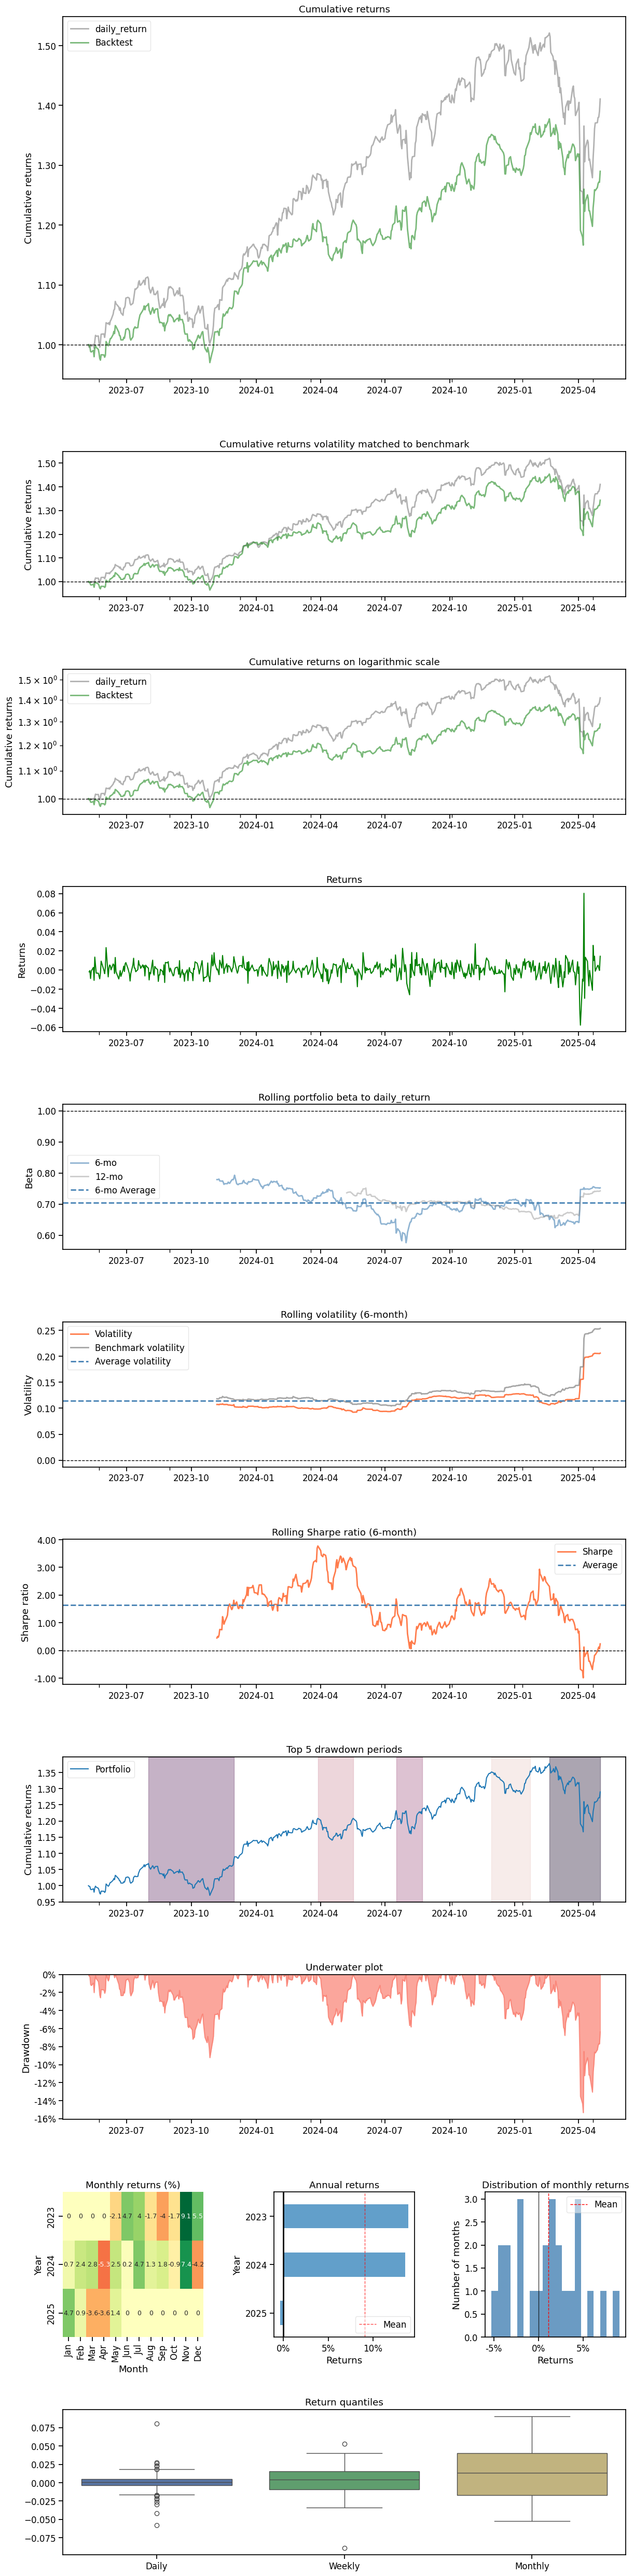

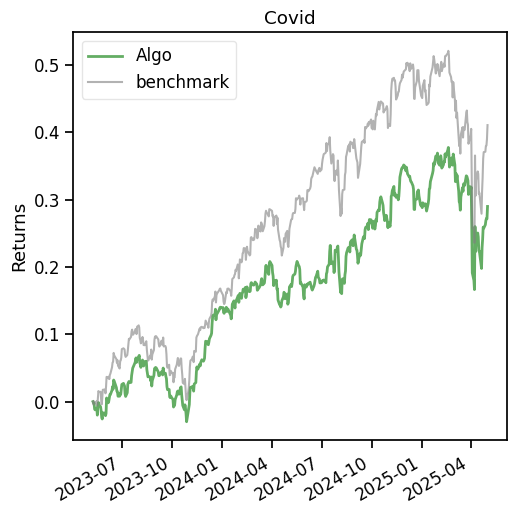

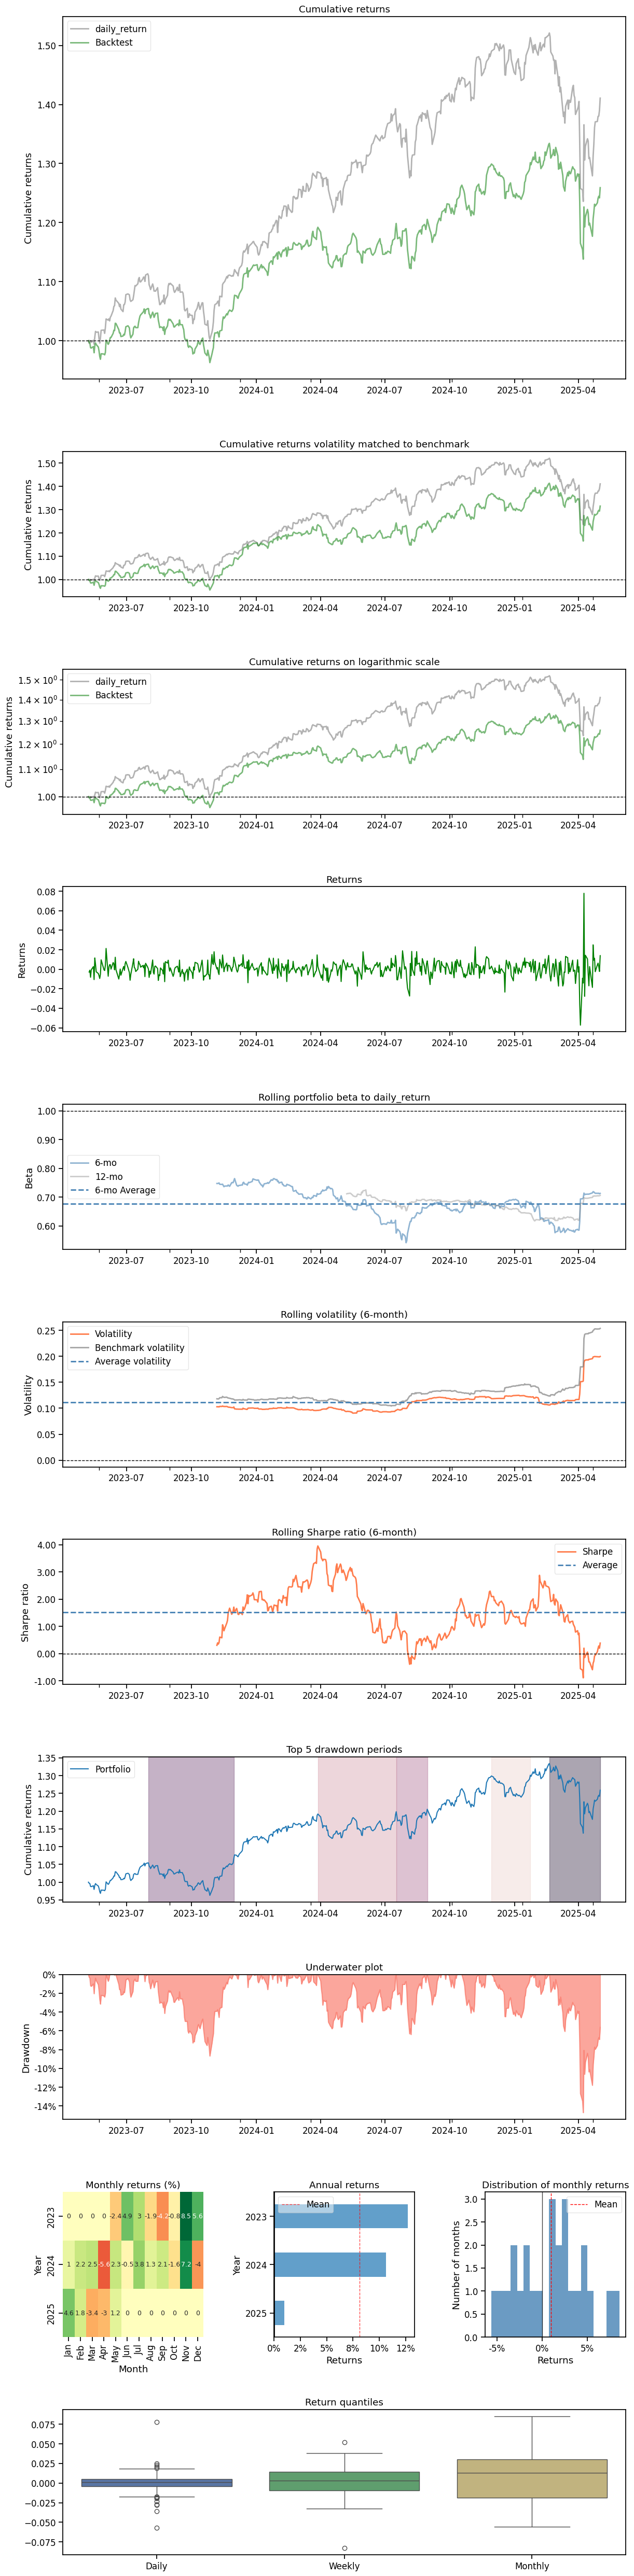

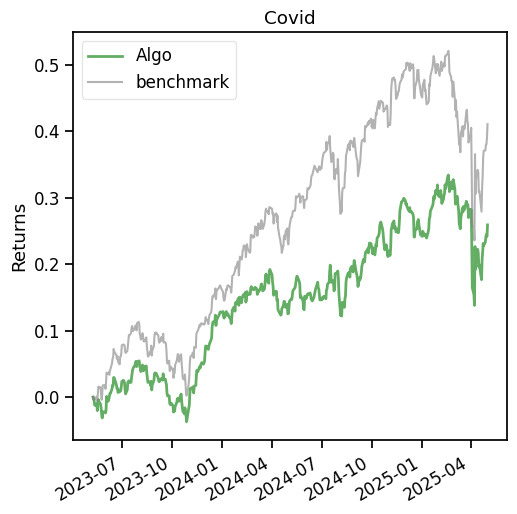

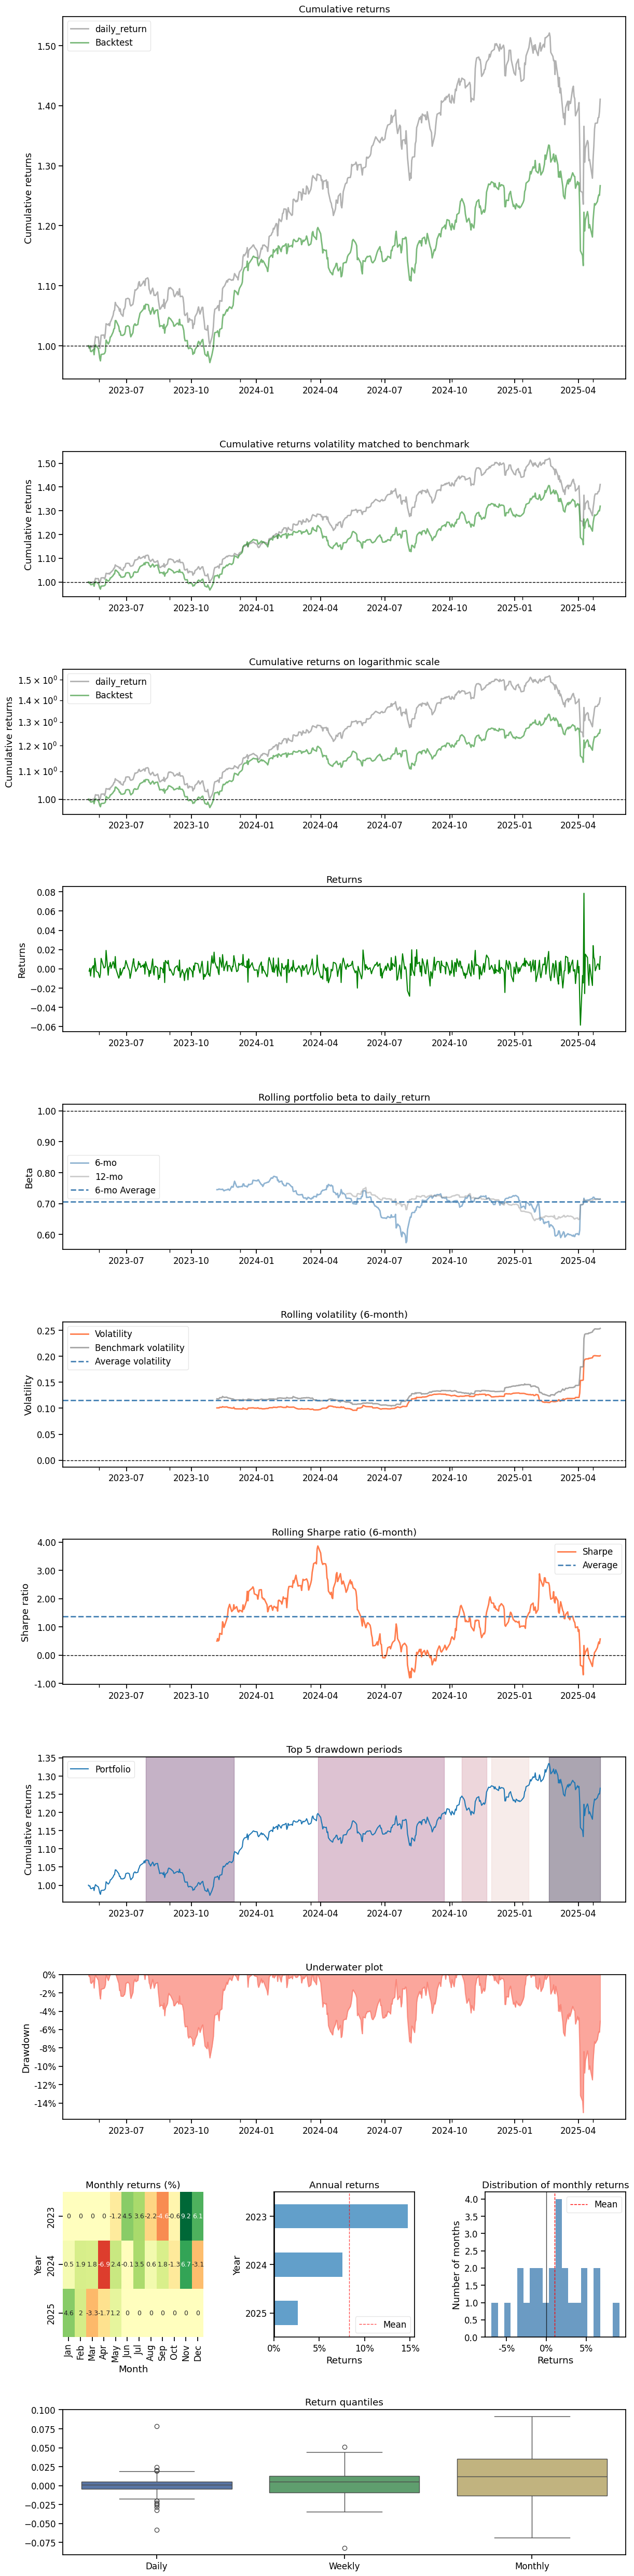

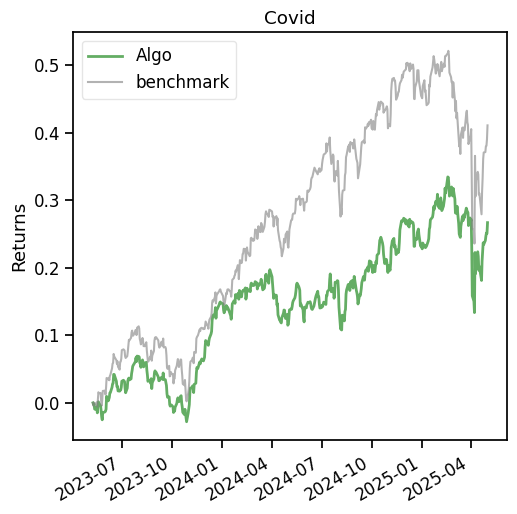

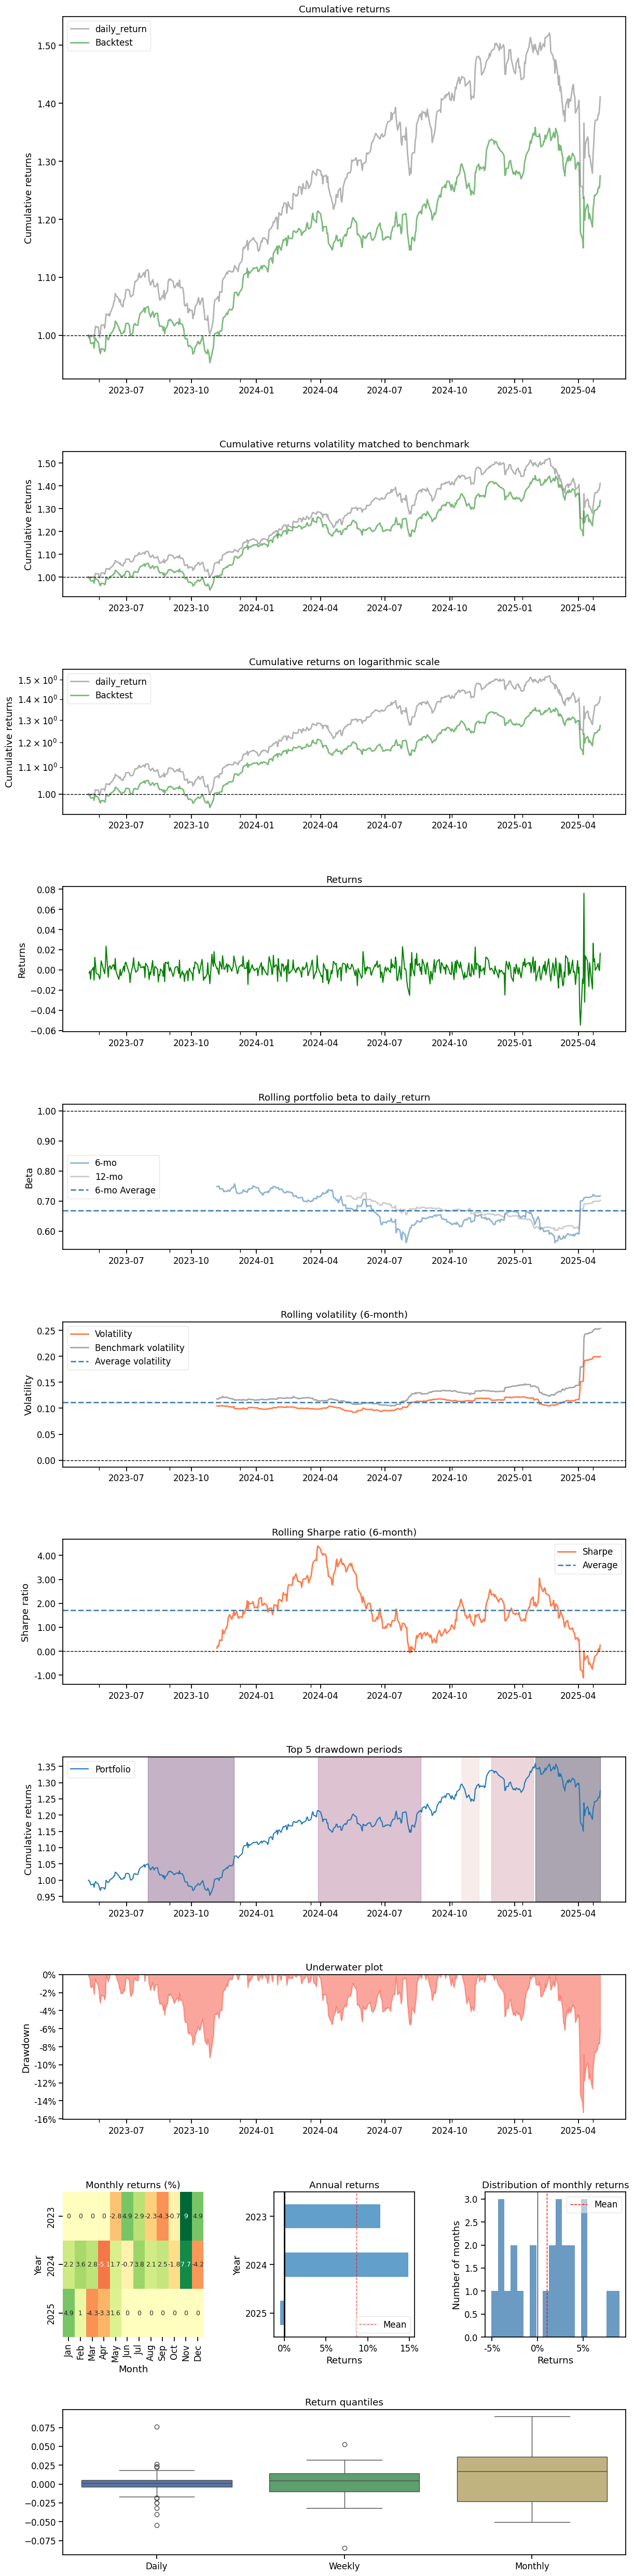

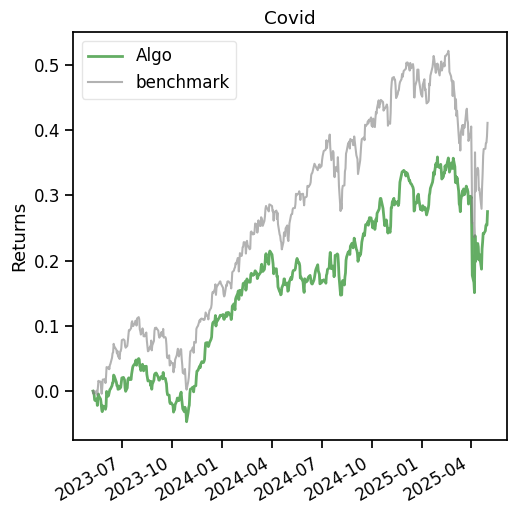

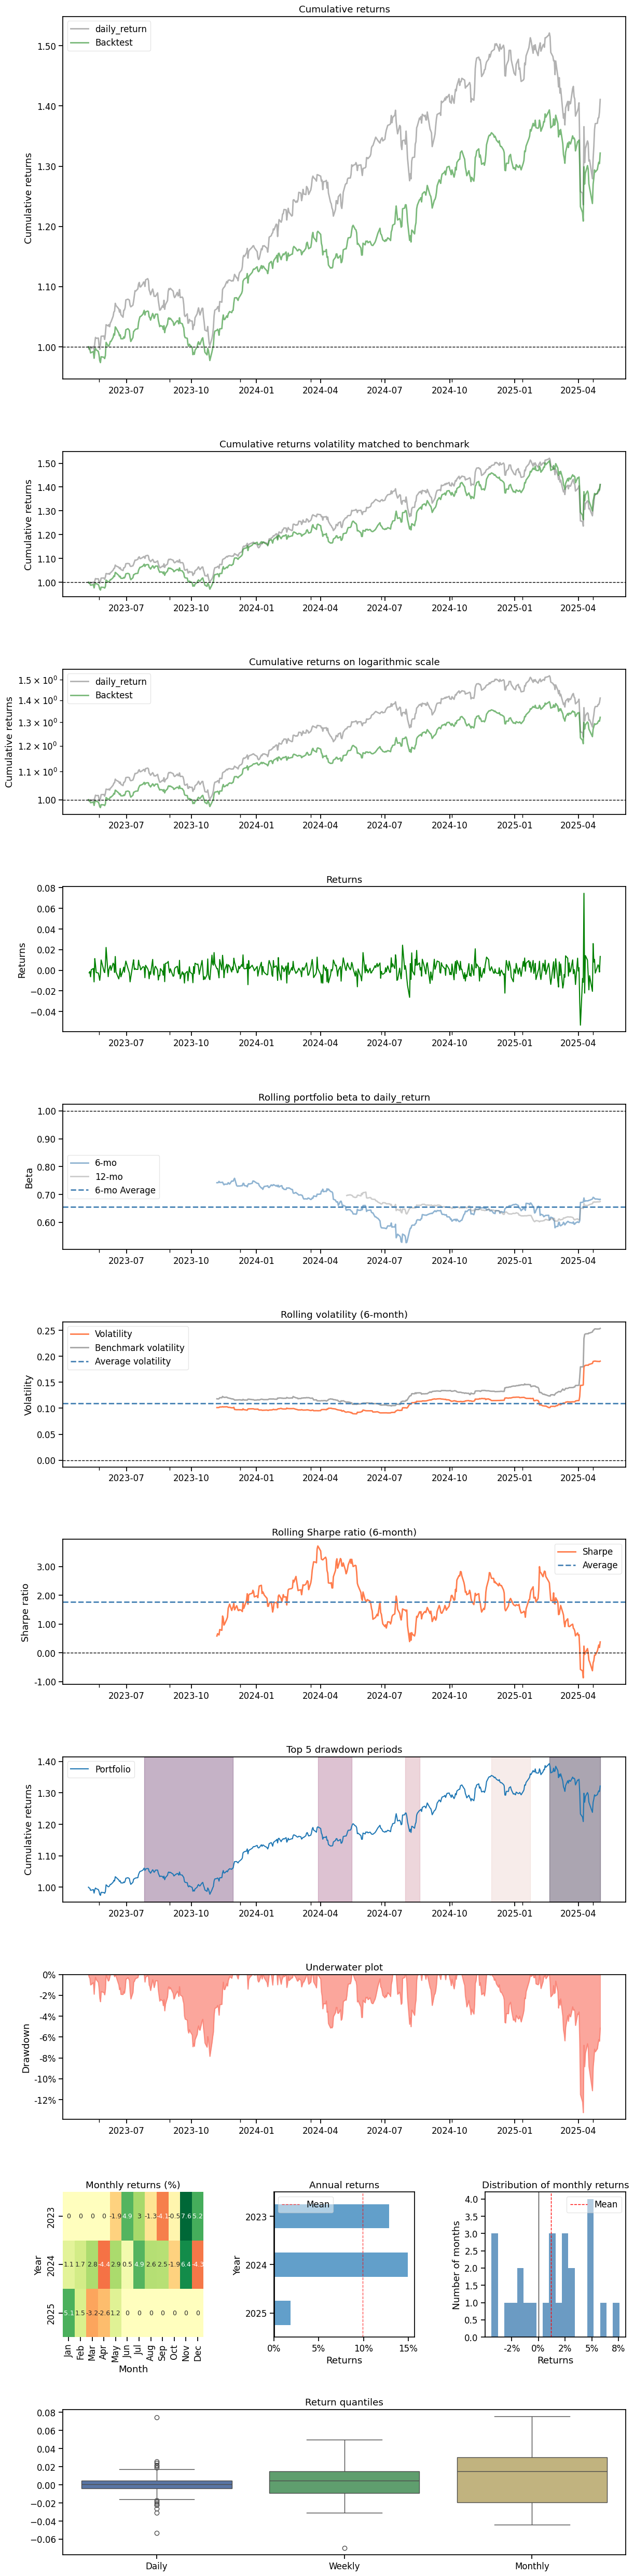

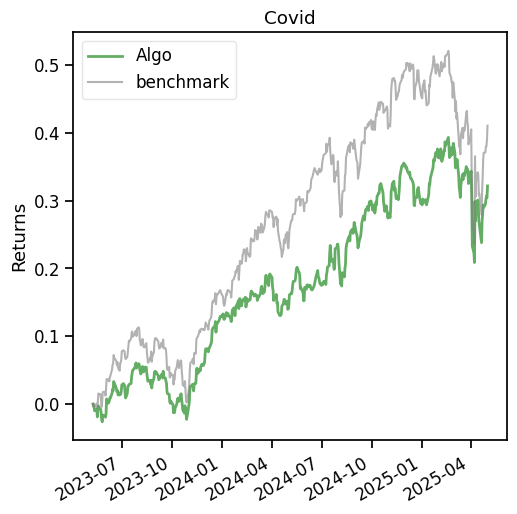

In [90]:
def plot_backtest_results():
    for name, res in results.items():
        print(f"Plotting {name}…")
        backtest_plot(
            account_value=res["df"],
            baseline_start=test_start_date,
            baseline_end=end_date,
            baseline_ticker="SPY",
            value_col_name="account_value",
        )

plot_backtest_results()

## Benchmarks


These benchmarks will provide baseline performance metrics for comparison with the RL strategies.
We evaluate the performance of **Mean-Variance Optimization (MVO)** and simple benchmarks (**Equal-Weighted Portfolio** and **SPY**) in terms of returns, volatility, and cumulative portfolio value.


### Mean-Variance Optimization Benchmark

- **Objective**: Calculate the benchmark portfolio using **Mean-Variance Optimization (MVO)**.
- **Purpose**: This function benchmarks the performance of a portfolio optimized for minimum volatility using **Modern Portfolio Theory (MPT)**.
- **Comparison**: It allows us to compare the MPT strategy with other RL strategies by analyzing metrics like returns, volatility, and cumulative performance.

##### Workflow:

1. **Covariance Matrix**:

   - Extract the covariance matrix of asset returns for each trading day in the test period.
   - Use this matrix to model the relationships between asset returns.

2. **Optimization**:

   - Apply **Efficient Frontier** to minimize portfolio volatility.
   - Compute the optimal weights for each asset in the portfolio.

3. **Portfolio Value Calculation**:

   - Calculate the portfolio's account value over time using the optimized weights and asset prices.

4. **Performance Metrics**:
   - Evaluate the portfolio's performance using metrics such as annual return, cumulative return, and volatility.
   - Add the results to the `results` dictionary under the `"MPT"` key.


In [91]:
def compute_mpt_benchmark(test, env_kwargs):
    dates_test = test.date.unique()
    min_vals = [env_kwargs["initial_amount"]]
    for i in range(len(dates_test) - 1):
        curr = test[test.date == dates_test[i]]
        nxt = test[test.date == dates_test[i + 1]]
        covm = np.array(curr.cov_list.values[0])
        ef = EfficientFrontier(None, covm, weight_bounds=(0, 1))
        ef.min_volatility()
        w = ef.clean_weights()
        prices = curr.close.values
        nextp = nxt.close.values
        shares = np.array(list(w.values())) * min_vals[-1] / prices
        min_vals.append(np.dot(shares, nextp))
    min_df = pd.DataFrame({"date": dates_test, "account_value": min_vals})
    stats_mpt = backtest_stats(min_df, value_col_name="account_value")
    return {"df": min_df, "stats": stats_mpt}


mpt_benchmark = compute_mpt_benchmark(test, env_kwargs)

Annual return          0.072786
Cumulative returns     0.149266
Annual volatility      0.110877
Sharpe ratio           0.690351
Calmar ratio           0.695330
Stability              0.846594
Max drawdown          -0.104678
Omega ratio            1.133351
Sortino ratio          0.997036
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.023862
Daily value at risk   -0.013665
dtype: float64


### Equal-Weighted Portfolio Benchmark

- Calculate the performance of an **equal-weighted portfolio** benchmark.
- This benchmark assumes that all assets in the portfolio are equally weighted, and their daily returns are averaged to compute the portfolio's overall return.

##### Workflow:

1. **Daily Returns Calculation**:

   - Group the test dataset by `date`.
   - Compute the percentage change (`pct_change`) in the `close` prices for each group.
   - Calculate the mean of the daily percentage changes to represent the portfolio's daily return.

2. **Cumulative Portfolio Value**:

   - Reset the index of the daily returns to create a DataFrame (`ew_df`).
   - Compute the cumulative product of the daily returns (`cumprod`) to calculate the portfolio's cumulative value over time.
   - Multiply the cumulative returns by the initial portfolio value (`initial_amount`) to get the portfolio's account value.

3. **Performance Metrics**:
   - Use the `backtest_stats` function to calculate performance metrics for the equal-weighted portfolio, such as annual return, cumulative return, and volatility.


In [92]:
def compute_equal_weighted_benchmark(df, initial_amount=100_000):
    # Pivot to have one column per ticker
    price_wide = df.pivot_table(
        index="date", columns="tic", values="close"
    ).sort_index()

    # Compute each ticker's daily return, then average equally
    daily_rets = price_wide.pct_change().fillna(0).mean(axis=1)

    # Build the equity curve
    ew_df = pd.DataFrame({"date": daily_rets.index, "daily_return": daily_rets.values})
    ew_df["account_value"] = (ew_df["daily_return"] + 1).cumprod() * initial_amount

    # Compute performance statistics
    stats_ew = backtest_stats(ew_df, value_col_name="account_value")

    return {"df": ew_df.reset_index(drop=True), "stats": stats_ew}


ew_benchmark = compute_equal_weighted_benchmark(test, env_kwargs["initial_amount"])

Annual return          0.123424
Cumulative returns     0.259170
Annual volatility      0.135292
Sharpe ratio           0.929446
Calmar ratio           0.839559
Stability              0.864078
Max drawdown          -0.147010
Omega ratio            1.186632
Sortino ratio          1.374410
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.993978
Daily value at risk   -0.016546
dtype: float64


### SPY Benchmark

- **Objective**: Calculate the benchmark performance of the `SPY ETF`, which tracks the **S&P 500** index.
- **Purpose**: This function provides a baseline for comparing the performance of reinforcement learning models and other portfolio strategies.

##### Workflow:

1. **Data Retrieval**:
   - Use the `get_baseline` function to fetch the historical closing prices of the SPY ETF for the test period.
2. **Daily Returns Calculation**:
   - Compute the percentage change (`pct_change`) in the SPY closing prices to calculate daily returns.
3. **Cumulative Portfolio Value**:
   - Create a DataFrame (`spy_df`) with the daily returns and calculate the cumulative product (`cumprod`) of the daily returns to compute the portfolio's cumulative value over time.
   - Multiply the cumulative returns by the initial portfolio value (`initial_amount`) to get the portfolio's account value.
4. **Performance Metrics**:
   - Use the `backtest_stats` function to calculate performance metrics for the SPY benchmark, such as annual return, cumulative return, and volatility.


In [93]:
def compute_spy_benchmark(test, env_kwargs):
    spy_close = get_baseline("SPY", test_start_date, end_date)['close']
    spy_ret = spy_close.pct_change().dropna()
    spy_df = pd.DataFrame({"date": spy_ret.index, "daily_return": spy_ret.values})
    spy_df["account_value"] = (spy_df.daily_return + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats_spy = backtest_stats(spy_df, value_col_name="account_value")
    return {"df": spy_df, "stats": stats_spy}


spy_benchmark = compute_spy_benchmark(test, env_kwargs)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (499, 8)
Annual return          0.192877
Cumulative returns     0.416994
Annual volatility      0.163758
Sharpe ratio           1.160676
Calmar ratio           1.028393
Stability              0.865753
Max drawdown          -0.187552
Omega ratio            1.250589
Sortino ratio          1.727364
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.913992
Daily value at risk   -0.019877
dtype: float64


In [94]:
benchmarks = {
    "MPT": mpt_benchmark,
    "EW": ew_benchmark,
    "SPY": spy_benchmark,
}

results.update(benchmarks)

## Performance Summary


In [95]:
perf_stats = pd.DataFrame({key.upper(): res["stats"] for key, res in results.items()})
display(perf_stats)

A2C       PPO       SAC      DDPG       TD3  \
Annual return        0.137209  0.123405  0.126854  0.130494  0.151307   
Cumulative returns   0.289950  0.259128  0.266794  0.274911  0.321807   
Annual volatility    0.139147  0.135292  0.137516  0.135336  0.130730   
Sharpe ratio         0.995322  0.929320  0.938839  0.975685  1.145210   
Calmar ratio         0.895235  0.839202  0.842793  0.852742  1.142138   
Stability            0.881547  0.864077  0.833189  0.860530  0.915068   
Max drawdown        -0.153266 -0.147050 -0.150516 -0.153029 -0.132477   
Omega ratio          1.203785  1.186637  1.186531  1.196304  1.232371   
Sortino ratio        1.481574  1.374337  1.384091  1.440125  1.738766   
Skew                      NaN       NaN       NaN       NaN       NaN   
Kurtosis                  NaN       NaN       NaN       NaN       NaN   
Tail ratio           1.031055  0.993396  0.987012  1.030303  1.042896   
Daily value at risk -0.016981 -0.016546 -0.016813 -0.016527 -0.015876   

                          MPT        EW       SPY  
Annual return        0.072786  0.123424  0.192877  
Cumulative returns   0.149266  0.259170  0.416994  
Annual volatility    0.110877  0.135292  0.163758  
Sharpe ratio         0.690351  0.929446  1.160676  
Calmar ratio         0.695330  0.839559  1.028393  
Stability            0.846594  0.864078  0.865753  
Max drawdown        -0.104678 -0.147010 -0.187552  
Omega ratio          1.133351  1.186632  1.250589  
Sortino ratio        0.997036  1.374410  1.727364  
Skew                      NaN       NaN       NaN  
Kurtosis                  NaN       NaN       NaN  
Tail ratio           1.023862  0.993978  0.913992  
Daily value at risk -0.013665 -0.016546 -0.019877

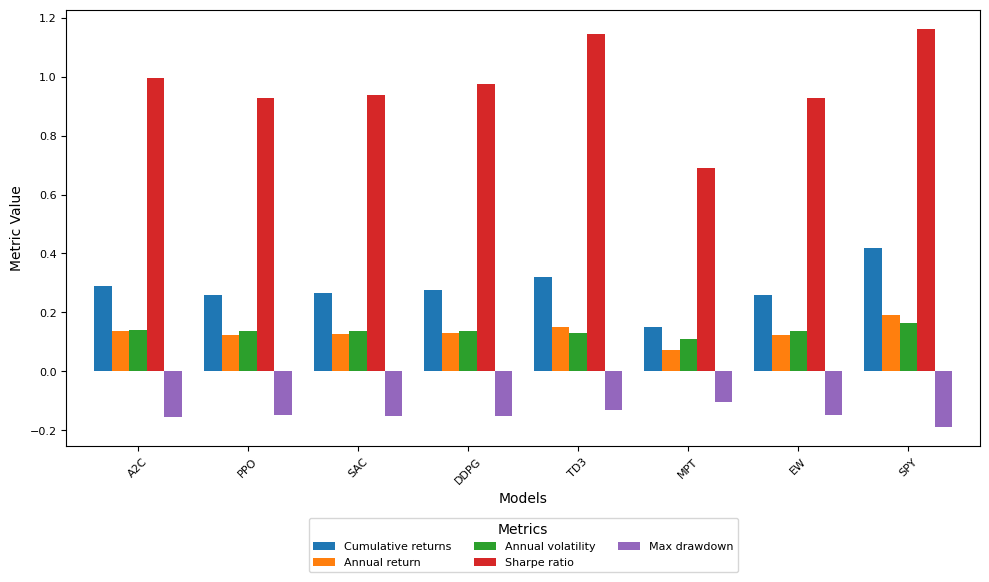

In [96]:
comparison_metrics = [
    "Cumulative returns",
    "Annual return",
    "Annual volatility",
    "Sharpe ratio",
    "Max drawdown",
]

# Filter the performance statistics for the selected metrics
comparison_table = perf_stats.loc[comparison_metrics]


# Plot the comparison metrics as a compact bar chart
comparison_table.T.plot(kind='bar', figsize=(10, 6), width=0.8)
# plt.title("Comparison of Key Metrics Across Models", fontsize=12)
plt.ylabel("Metric Value", fontsize=10)
plt.xlabel("Models", fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.legend(title="Metrics", loc='lower center', bbox_to_anchor=(0.5, -0.3), fontsize=8, ncol=3)
plt.tight_layout()
plt.show()


Visualize the cumulative returns of various strategies over time


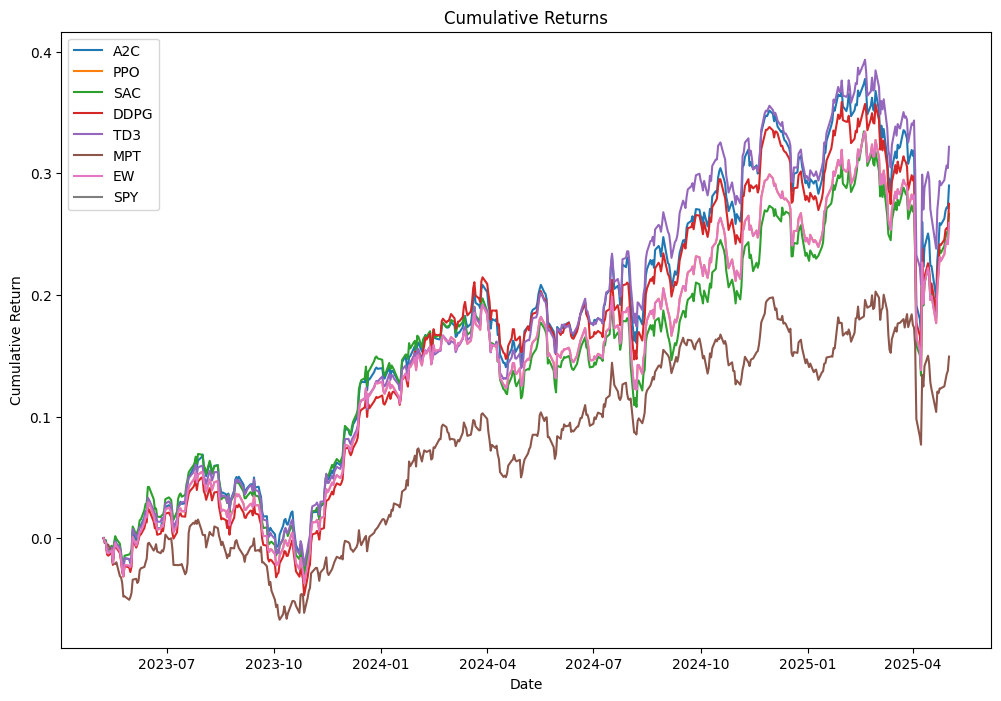

In [97]:
def plot_cumulative_returns(results):
    plt.figure(figsize=(12, 8))
    for name, res in results.items():
        # Ensure the date column is converted to datetime
        res["df"]["date"] = pd.to_datetime(res["df"]["date"])
        # Filter data to start from the trade start date
        filtered_df = res["df"][res["df"]["date"] >= test_start_date]
        cum = (
            (filtered_df["daily_return"] + 1).cumprod() - 1
            if "daily_return" in filtered_df
            else filtered_df["account_value"] / filtered_df["account_value"].iloc[0] - 1
        )
        plt.plot(filtered_df["date"], cum, label=name)
    plt.title("Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()

plot_cumulative_returns(results)